<a name="top" id="top"></a>

<div align="center">
    <h1>Benchmarking</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
    <a href="https://github.com/pedromxavier">Pedro Maciel Xavier</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Computer Science &amp; Systems Engineering Program, Federal University of Rio de Janeiro</i>
    <br>
    <br>
    <a href="https://github.com/murraybj">Benjamin J. L. Murray</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Undergraduate Research Assistant</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/SECQUOIA/QUBONotebooks/blob/main/notebooks_py/5-Benchmarking_python.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

## Benchmarking

### About this Notebook

With the new availability of unconventional hardware, novel algorithms, and increasingly optimized software to address optimization problems; the first question that arises is, which one is better?
We will call the combination of hardware, algorithm, and software within a solution method a solver.
This question is also relevant when evaluating a single solver, given that usually they rely on hyperparameters, for which the quesiton now becomes, which is the best parameter setting for a given solver?
These questions obviously depend on the problem that one is trying to solve. The solution of the problem also depends on the budget of resources that one has available.

In the case that the available resources are relatively "unlimited" and that the problem to solve is known, one could exhaustively try all the parameter settings within a delimited range for that instance and choose which one is the best.
This case is idealistic, in the sense that usually one does not know a-priori which problem is there to solve (and if while testing all the parameters you solve it, what would be the point of identifying the best parameters?), and that there exists limitations in terms of resources, e.g., time, memory, or energy, when trying to address these problems.
A case closer to reality is where you have the chance of solving problems that look similar to the one that you are interested in solving later, either because you have previously generated problems or you have identified a feature that characterizes your problem of interest and can generate random instances, which we will call as a family of instances.
Then, you can use a larger amount of resources to solve that family of problems "off-line", meaning that you spend extra resources to address the problems in your family of instances although it is unrelated to the actual application.
Finally, you would like to use the results that you found off-line as a guidance to solve your unknown problem more efficiently.

### Example
For illustration purposes, we will use an example that you are already familiar with, which is an Ising model. As a solver, we will use a simulated annealing code provided by D-Wave Ocean Tools.

### Ising model
In order to implement the different Ising Models we will use D-Wave's packages **[dimod](https://github.com/dwavesystems/dimod)** and **[neal](https://github.com/dwavesystems/dwave-neal)**, for defining the Ising model and solving it with simulated annealing, respectively.

### Problem statement

We pose the Ising problem as the following optimization problem:

$$
\min_{s \in \{ \pm 1 \}^n} H(s) = \min_{s \in \{ \pm 1 \}^n} \sum_{(i, j) \in E(G)} J_{i,j}s_is_j + \sum_{i \in V(G)} h_is_i + \beta
$$

where we optimize over spins $s \in \{ \pm 1 \}^n$, on a constrained graph $G(V,E)$, where the quadratic coefficients are $J_{i,j}$ and the linear coefficients are $h_i$.
We also include an arbitrary offset of the Ising model $\beta$.

### Example

Suppose we have an Ising model defined from

$$
h = \begin{bmatrix}
145.0 \\ 122.0 \\ 122.0 \\ 266.0 \\ 266.0 \\ 266.0 \\ 242.5 \\ 266.0 \\ 386.5 \\ 387.0 \\ 386.5
\end{bmatrix},
J = \begin{bmatrix}
0 & 0 & 0 & 24 & 24 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 48 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72 & 72\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix} \text{ and }
c_I = 1319.5
$$

Let's solve this problem

In [1]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's install with dimod and neal
if IN_COLAB:
    !pip install -q pyomo
    !pip install dimod
    !pip install dwave-neal

In [2]:
# Import the Pyomo library, which can be installed via pip, conda or from Github https://github.com/Pyomo/pyomo
import pyomo.environ as pyo
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx
import os
import pickle
from scipy import stats
from matplotlib import ticker

In [3]:
# These could also be simple lists and numpy matrices
h = {0: 145.0, 1: 122.0, 2: 122.0, 3: 266.0, 4: 266.0, 5: 266.0, 6: 242.5, 7: 266.0, 8: 386.5, 9: 387.0, 10: 386.5}
J = {(0, 3): 24.0, (0, 4): 24.0, (0, 5): 24.0, (0, 7): 24.0, (0, 8): 24.0, (0, 9): 24.0, (0, 10): 24.0, (1, 3): 24.0, (1, 5): 24.0, (1, 6): 24.0, (1, 8): 24.0, (1, 9): 24.0, (1, 10): 24.0, (2, 4): 24.0, (2, 6): 24.0, (2, 7): 24.0, (2, 8): 24.0, (2, 9): 24.0, (2, 10): 24.0, (3, 4): 24.0, (3, 5): 48.0, (3, 6): 24.0, (3, 7): 24.0, (3, 8): 48.0, (3, 9): 48.0, (3, 10): 48.0, (4, 5): 24.0, (4, 6): 24.0, (4, 7): 48.0, (4, 8): 48.0, (4, 9): 48.0, (4, 10): 48.0, (5, 6): 24.0, (5, 7): 24.0, (5, 8): 48.0, (5, 9): 48.0, (5, 10): 48.0, (6, 7): 24.0, (6, 8): 48.0, (6, 9): 48.0, (6, 10): 48.0, (7, 8): 48.0, (7, 9): 48.0, (7, 10): 48.0, (8, 9): 72.0, (8, 10): 72.0, (9, 10): 72.0}
cI = 1319.5


model_ising = dimod.BinaryQuadraticModel.from_ising(h, J, offset=cI) # define the model

/tmp/ipykernel_114151/1437022254.py:1: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  nx_graph = model_ising.to_networkx_graph()


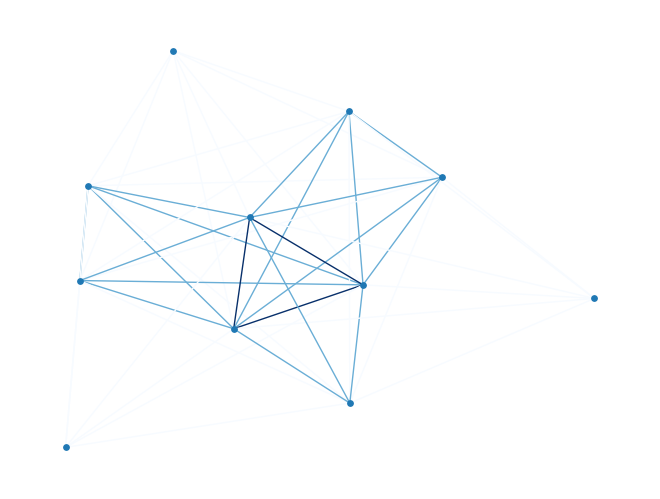

In [4]:
nx_graph = model_ising.to_networkx_graph()
edges, bias = zip(*nx.get_edge_attributes(nx_graph, 'bias').items())
bias = np.array(bias)
nx.draw(nx_graph, node_size=15, pos=nx.spring_layout(nx_graph),
        edgelist=edges, edge_color=bias, edge_cmap=plt.cm.Blues)


Since the problem is relatively small (11 variables, $2^{11}=2048$ combinations), we can afford to enumerate all the solutions.

In [5]:
exactSampler = dimod.reference.samplers.ExactSolver()
start = time.time()
exactSamples = exactSampler.sample(model_ising)
timeEnum = time.time() - start
print("runtime: " + str(timeEnum) + " seconds")

runtime: 0.0047452449798583984 seconds


In [6]:
# Some useful functions to get plots
def plot_energy_values(results, title=None):

    _, ax = plt.subplots()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by='energy')]

    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        ax.set(xlabel='bitstring for solution')
    else:
        samples = np.arange(len(energies))
        ax.set(xlabel='solution')

    ax.bar(samples, energies)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Energy')
    if title:
        ax.set_title(str(title))
    print("minimum energy:", min(energies))
    return ax


def plot_samples(results, title=None, skip=1):
    _, ax = plt.subplots()
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        ax.set_xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        ax.set_xlabel('solution')

    counts = Counter(samples)
    total = len(samples)
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None, ax=ax)

    ax.tick_params(axis='x', rotation=80)
    ax.set_xticklabels([t.get_text()[:7] if not i%skip else "" for i,t in enumerate(ax.get_xticklabels())])
    ax.set_ylabel('Probabilities')
    if title:
        ax.set_title(str(title))
    print("minimum energy:", min(energies))
    return ax


def plot_energy_cfd(results, title=None, skip=1):
    _, ax = plt.subplots()
    # skip parameter given to avoid putting all xlabels
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None, ax = ax)
    ax.set_xticklabels([t.get_text()[:7] if not i%skip else "" for i,t in enumerate(ax.get_xticklabels())])

    ax.set_xlabel('Energy')
    ax.set_ylabel('Probabilities')
    if title:
        ax.set_title(str(title))
    print("minimum energy:", min(energies))
    return ax

minimum energy: 5.0


minimum energy: 5.0


<Axes: title={'center': 'Enumerate all solutions'}, xlabel='Energy', ylabel='Probabilities'>

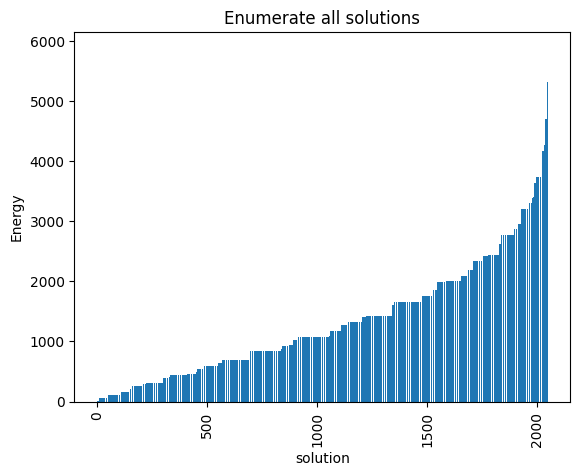

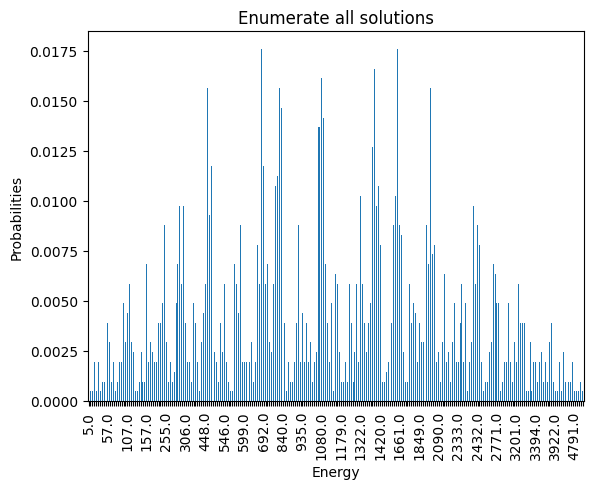

In [7]:
plot_energy_values(exactSamples, title='Enumerate all solutions')
plot_energy_cfd(exactSamples, title='Enumerate all solutions', skip=10)

We observe that the optimal solution of this problem is $x_{10} = 1, 0$ otherwise, leading to an objective of $5$. Notice that this problem has a degenerate optimal solution given that $x_8 = 1, 0$ otherwise also leads to the same solution.

Let's now solve this problem using Simulated Annealing

In [8]:
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(model_ising, num_reads=1000)

minimum energy: 5.0
minimum energy: 5.0


<Axes: title={'center': 'Simulated annealing in default parameters'}, xlabel='Energy', ylabel='Probabilities'>

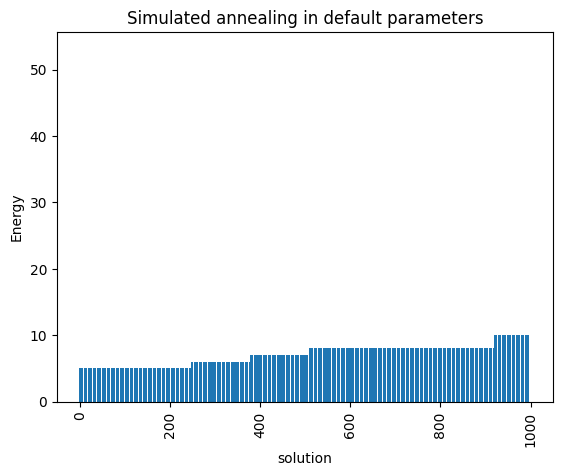

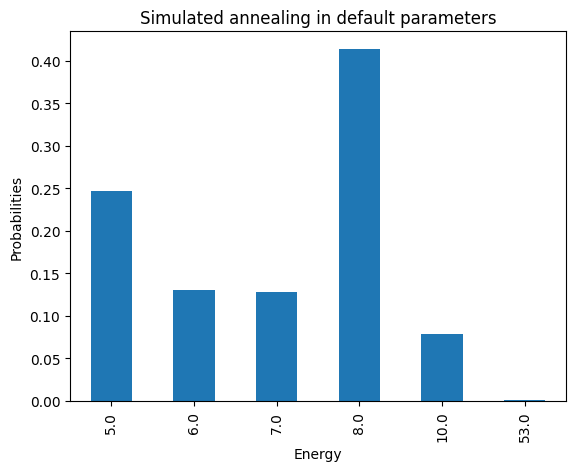

In [9]:
plot_energy_values(simAnnSamples, title='Simulated annealing in default parameters')
plot_energy_cfd(simAnnSamples, title='Simulated annealing in default parameters')

We are going to use the default limits of temperature given by the simulating annealing code. These are defined using the minimum and maximum nonzero coefficients in the Ising model. Then the range for beta is defined as 

$$
\beta \in \left[ \frac{\log(2)}{\max \{ \Delta E \} },\frac{\log(100)}{\min \{ \Delta E \} } \right]
$$

where

$$
\Delta E = \min_{i} \{h_i \} + \sum_j J_{ij}+J_{ji}
$$

Hot temperature: We want to scale hot_beta so that for the most unlikely qubit flip, we get at least 50% chance of flipping. (This means all other qubits will have > 50% chance of flipping initially). Most unlikely flip is when we go from a very low energy state to a high energy state, thus we calculate hot_beta based on max_delta_energy.

$$
0.50 = \exp(-\overline{\beta} * \max \{ \Delta E \})
$$

Cold temperature: Towards the end of the annealing schedule, we want to minimize the chance of flipping. Don't want to be stuck between small energy tweaks. Hence, set cold_beta so that at minimum energy change, the chance of flipping is set to 1%.

$$
0.01 = \exp(-\underline{\beta} * \min \{ \Delta E \})
$$

By default, the schedule also follows a geometric series.

In [10]:
def geomspace(a, b, length=100):
    return np.logspace(np.log10(a), np.log10(b), num=length, endpoint=True)

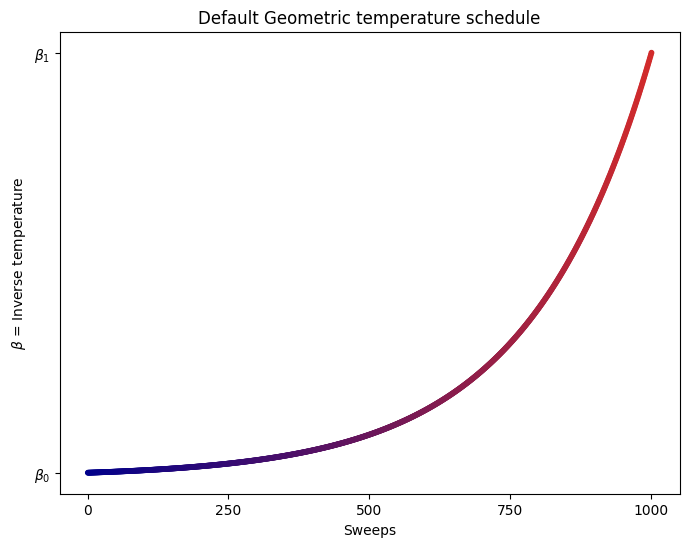

In [11]:
def hex_to_RGB(hex_str):
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

def plot_schedule(beta1, beta2, length=1000):
    color1 = "#00008b"
    color2 = "#D22B2B"
    sweeps = np.linspace(np.log10(2), np.log10(100), num=length, endpoint=True)
    beta = np.geomspace(beta1, beta2, num=length)
    plt.figure(figsize=(8, 6))
    plt.scatter(x=sweeps, 
                y=beta, 
                color = get_color_gradient(color1, color2, len(beta)), 
                s=10)
    plt.title("Default Geometric temperature schedule")
    plt.xlabel("Sweeps")
    plt.ylabel(r"$ \beta $ = Inverse temperature")
    plt.xticks([sweeps[0], sweeps[249], sweeps[499], sweeps[749], sweeps[999]], [0,250,500,750,1000])
    plt.yticks([beta1, beta2], [r"$ \beta_{0} $", r"$ \beta_{1} $"])
    plt.grid(False)
    plt.show()

beta1 = 0.1
beta2 = 10
plot_schedule(beta1, beta2)


Now let's compute an expected time metric with respect to the number of sweeps in simulated annealing.

In [12]:
s = 0.99
# sweeps = list(chain(np.arange(1,10,1),np.arange(10,30,2), np.arange(30,50,5), np.arange(50,100,10) ,np.arange(100,1001,100)))
sweeps = list(chain(np.arange(1, 250, 1), np.arange(250, 1001, 10)))
schedules = ['geometric','linear']
opt_energy = 5
results = {}
results['p'] = {}
results['tts'] = {}
results['t']= {}
for schedule in schedules:
    probs = []
    time_to_sol = []
    times = []
    for sweep in sweeps:
        start = time.time()
        samples = simAnnSampler.sample(model_ising, num_reads=1000, num_sweeps=sweep, beta_schedule_type=schedule)
        time_s = time.time() - start
        energies=samples.data_vectors['energy']
        occurrences = samples.data_vectors['num_occurrences']
        total_counts = sum(occurrences)
        counts = {}
        for index, energy in enumerate(energies):
            if energy in counts.keys():
                counts[energy] += occurrences[index]
            else:
                counts[energy] = occurrences[index]
        pr = sum(counts[key]
                 for key in counts.keys() if key <= opt_energy)/total_counts
        probs.append(pr)
        if pr == 0:
            time_to_sol.append(np.inf)
        else:
            time_to_sol.append(time_s*math.log10(1-s)/math.log10(1-pr))
        times.append(time_s)
    results['p'][schedule] = probs
    results['tts'][schedule] = time_to_sol
    results['t'][schedule] = times


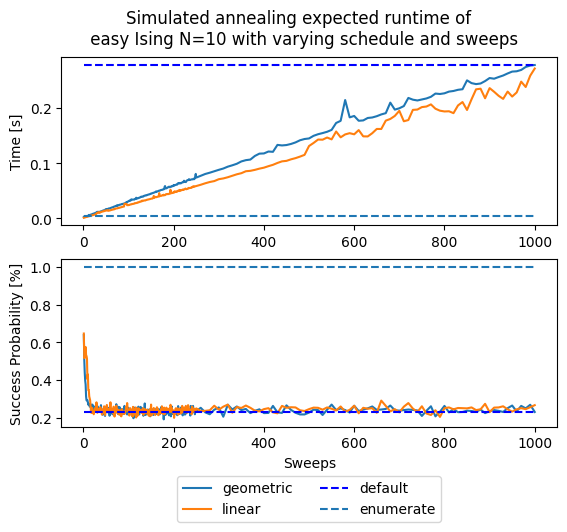

In [13]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Simulated annealing expected runtime of \n' +
             ' easy Ising N=10 with varying schedule and sweeps')

for schedule in schedules:
    ax1.plot(sweeps, results['t'][schedule], '-', label=schedule)
ax1.hlines(results['t']['geometric'][-1], sweeps[0], sweeps[-1],
           linestyle='--', label='default', colors='b')
ax1.hlines(timeEnum, sweeps[0], sweeps[-1], linestyle='--', label='enumerate')

ax1.set(ylabel='Time [s]')

for schedule in schedules:
    ax2.plot(sweeps, results['p'][schedule], '-', label=schedule)
ax2.hlines(results['p']['geometric'][-1], sweeps[0], sweeps[-1],
           linestyle='--', label='default', colors='b')
ax2.hlines(1, sweeps[0], sweeps[-1], linestyle='--', label='enumerate')

ax2.set(ylabel='Success Probability [%]')
ax2.set(xlabel='Sweeps')

plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.25))


These plots represent ofter contradictory metrics, on one hand you would like to obtain a large probability of finding a right solution (the deffinition of right comes from what you define as success). On the other hand, the time it takes to solve these cases should be as small as possible.
This is why we are interested in a metric that combines both, and that is why we settle on the Time To Solution (TTS) which is defined as

$$
TTS = \frac{\log{1-s}}{\log{1-p}}
$$

where s is a success factor, usually takes as $s = 99\%$, and $p$ is the success probability, usually accounted as the observed success probability.

One usually reads this as the time to solution within 99\% probability.

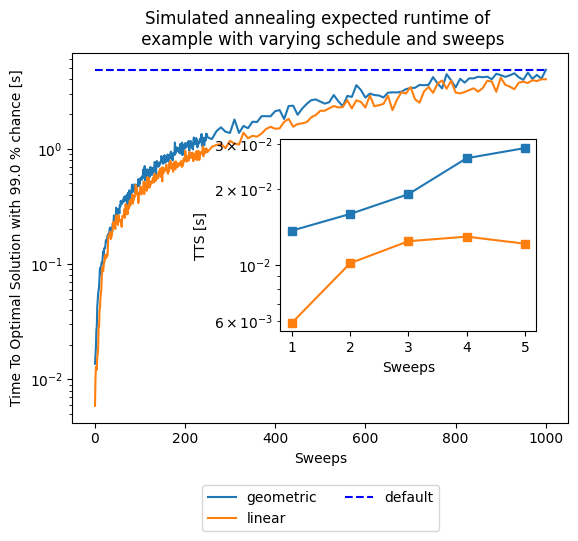

In [14]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
for schedule in schedules:
    ax1.semilogy(sweeps, results['tts'][schedule], '-', label=schedule)


# Value for the default solution
ttsDefault = results['tts']['geometric'][-1]
ax1.hlines(ttsDefault, sweeps[0], sweeps[-1], linestyle='--', label='default', colors='b')


ax1.set_ylabel('Time To Optimal Solution with ' + str(s*100) +' % chance [s]')
ax1.set_xlabel('Sweeps')
ax1.set_title('Simulated annealing expected runtime of \n' + ' example with varying schedule and sweeps')

ax2 = plt.axes([.45, .3, .4, .4])
for schedule in schedules:
    ax2.semilogy(sweeps[0:5],results['tts'][schedule][0:5],'-s')
ax2.set_ylabel('TTS [s]')
ax2.set_xlabel('Sweeps')


ax1.legend(ncol = 2, loc='upper center', bbox_to_anchor=(0.5, -0.15))


As you can notice, the default parameters given by D-Wave (number of sweeps = 1000 and a geometric update of $\beta$) are not optimal for our tiny example in terms of expected runtime.
This is certainly a function of the problem, for such a small instance having two sweeps are more than enough and more sweeps are an overkill.
This parameters choice might not generalize to any other problem, as seen below.

### Example 2
Let's define a larger model, with 100 variables and random weights, to see how this performance changes.

Assume that we are interested at the instance created with random weights $h_{i}, J_{i, j} \sim U[-1, +1]$.

In [15]:
N = 100 # Number of variables
np.random.seed(42) # Fixing the random seed to get the same result
J = np.random.rand(N,N)
J = np.triu(J, 1) # We only consider upper triangular matrix ignoring the diagonal
h = np.random.rand(N)

In [16]:
model_random = dimod.BinaryQuadraticModel.from_ising(h, J, offset=0.0)

/tmp/ipykernel_114151/1579279843.py:1: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  nx_graph = model_random.to_networkx_graph()


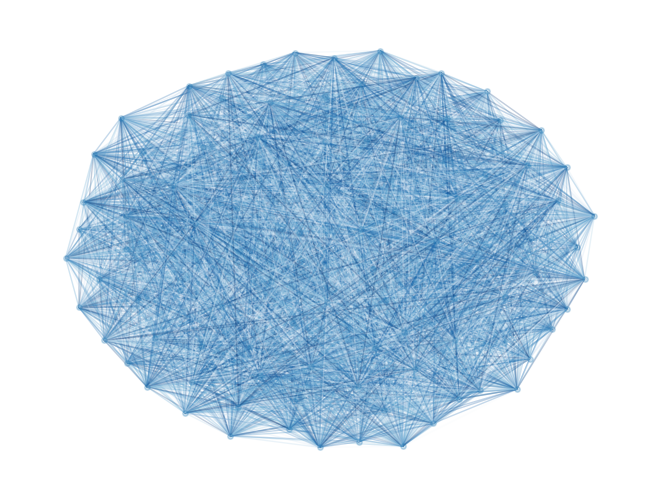

In [17]:
nx_graph = model_random.to_networkx_graph()
edges, bias = zip(*nx.get_edge_attributes(nx_graph, 'bias').items())
bias = np.array(bias)
nx.draw(nx_graph, node_size=15, pos=nx.spring_layout(nx_graph), alpha=0.25, edgelist=edges, edge_color=bias, edge_cmap=plt.cm.Blues)


For a problem of this size we cannot do a complete enumeration ($2^{100} \approx 1.2e30$) but we can randomly sample the distribution of energies to have a baseline for our later comparisons.

In [18]:
randomSampler = dimod.RandomSampler()
randomSample = randomSampler.sample(model_random, num_reads=1000)
energies = [datum.energy for datum in randomSample.data(
        ['energy'], sorted_by='energy')]
random_energy = np.mean(energies)
print('Average random energy:' + str(random_energy))

Average random energy:-0.2504200813470361


minimum energy: -79.53825499710057


<Axes: title={'center': 'Random sampling'}, xlabel='solution', ylabel='Energy'>

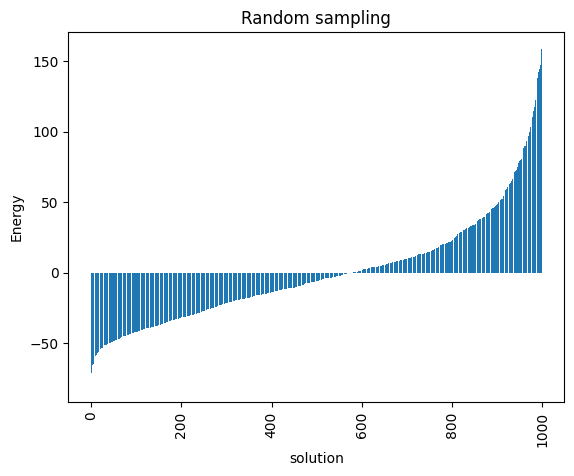

In [19]:
plot_energy_values(randomSample,
               title='Random sampling')

In [20]:
start = time.time()
simAnnSamplesDefault = simAnnSampler.sample(model_random, num_reads=1000)
timeDefault = time.time() - start
energies = [datum.energy for datum in simAnnSamplesDefault.data(
        ['energy'], sorted_by='energy')]
min_energy = energies[0]
print("minimum energy: " + str(min_energy))
print("runtime: " + str(timeDefault) + " seconds")


minimum energy: -236.4258051878277
runtime: 3.1673173904418945 seconds


### Problem statement

We pose the Ising problem as the following optimization problem:

$$
\min_{s \in \{ \pm 1 \}^n} H(s) = \min_{s \in \{ \pm 1 \}^n} \sum_{(i, j) \in E(G)} J_{i,j}s_is_j + \sum_{i \in V(G)} h_is_i + \beta
$$

where we optimize over spins $s \in \{ \pm 1 \}^n$, on a constrained graph $G(V,E)$, where the quadratic coefficients are $J_{i,j}$ and the linear coefficients are $h_i$.
We also include an arbitrary offset of the Ising model $\beta$.

minimum energy: -236.4258051878277


minimum energy: -236.4258051878277


<Axes: title={'center': 'Simulated annealing with default parameters'}, xlabel='Energy', ylabel='Probabilities'>

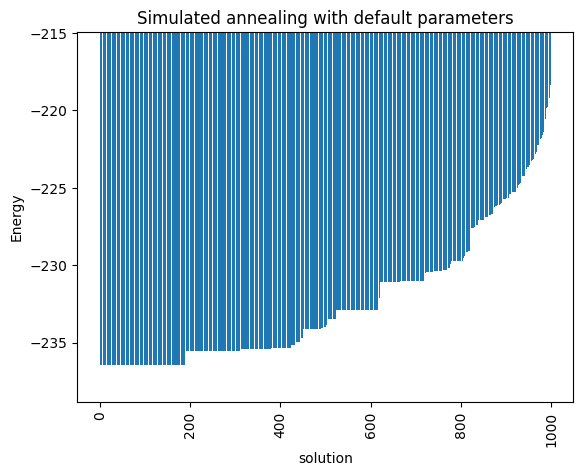

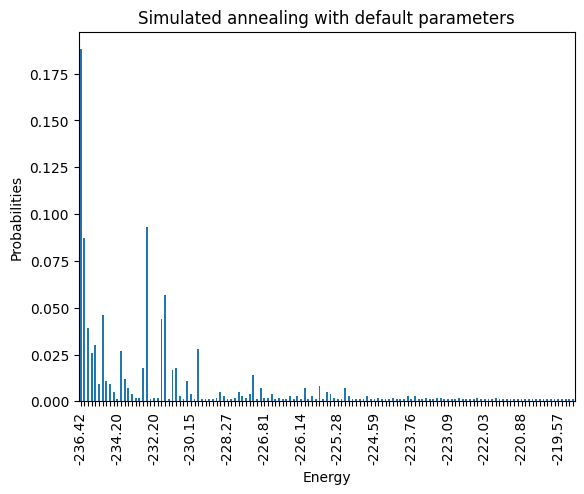

In [21]:
ax_enum = plot_energy_values(simAnnSamplesDefault,
               title='Simulated annealing with default parameters')
ax_enum.set(ylim=[min_energy*(0.99)**np.sign(min_energy),min_energy*(1.1)**np.sign(min_energy)])
plot_energy_cfd(simAnnSamplesDefault,
              title='Simulated annealing with default parameters', skip=10)


Notice that the minimum energy coming from the random sampling and the one from the simulated annealing are very different. 
Moreover, the distributions that both lead to are extremely different too.

{'beta_range': [0.0061437051318809005, 86238.87552721801], 'beta_schedule_type': 'geometric', 'timing': {'preprocessing_ns': 20513575, 'sampling_ns': 3146221946, 'postprocessing_ns': 435022}}


Text(0.5, 1.0, 'Default Geometric temperature schedule')

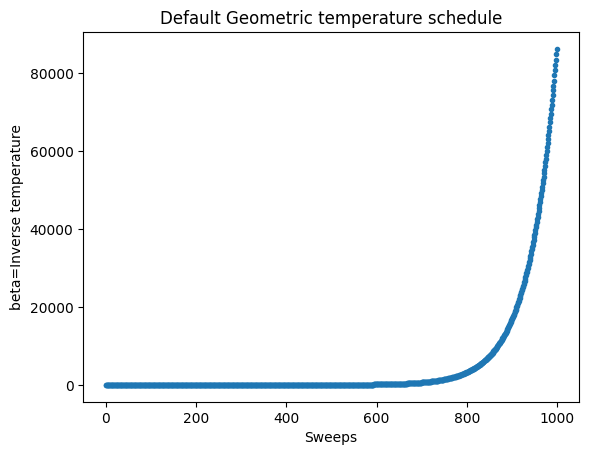

In [22]:
print(simAnnSamplesDefault.info)
beta_schedule = np.geomspace(*simAnnSamplesDefault.info['beta_range'], num=1000)
fig, ax = plt.subplots()
ax.plot(beta_schedule,'.')
ax.set_xlabel('Sweeps')
ax.set_ylabel('beta=Inverse temperature')
ax.set_title('Default Geometric temperature schedule')


We can solve this problem using IP such that we have guarantees that it is solved to optimality (this might be a great quiz for future lectures), but in this case let us define the "success" as getting an objective certain percentage of the best found solution in all cases (which we see it might not be even found with the default parameters).
To get a scaled version of this success equivalent for all instances, we will define this success with respect to the metric:

$$
\frac{found - random}{minimum - random}
$$

Where $found$ corresponds to the best found solution within our sampling, $random$ is the mean of the random sampling shown above, and $minimum$ corresponds to the best found solution to our problem during the exploration. Consider that this minimum might not be the global minimum.
This metric is very informative given that the best performance you can have is 1, being at the minimum, and negative values would correspond to a method that at best behaves worse that the random sampling.
Success now is counted as being within certain treshold of this value of 1.
This new way of measuring each method is very similar to the approximation ratio of approximation algorithms, therefore we will use that terminology from now on.

Before figuring out if we have the right optimal parameters, we want to save some effort by loading previously computed results.
If you do not want to load the results that we are providing, feel free to change the `overwrite_pickles` variable, at the expense that it will take some time (around 10 minutes per instance) to run.
Otherwise, a zip file with precomputed results will be downloaded from github.

In [23]:
current_path = os.getcwd()
pickle_path = os.path.join(current_path, 'results/')
if not(os.path.exists(pickle_path)):
    print('Results directory ' + pickle_path +
          ' does not exist. We will create it.')
    os.makedirs(pickle_path)
    !wget -O /content/results/results.zip -N -q "https://github.com/JuliaQUBO/QUBONotebooks/raw/main/notebooks_py/results.zip"

In [24]:
import zipfile
zip_name = os.path.join(pickle_path, 'results.zip')
overwrite_pickles = False
if os.path.exists(zip_name):
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(pickle_path)
    print('Results zip file has been extrated to ' + pickle_path)

Now either we have the pickled file or not, let us compute the statistics we are looking for.

In [25]:
s = 0.99 # This is the success probability for the TTS calculation
treshold = 5.0 # This is a percentual treshold of what the minimum energy should be
sweeps = list(chain(np.arange(1, 250, 1), np.arange(250, 1001, 10)))
# schedules = ['geometric', 'linear']
schedules = ['geometric']
total_reads = 1000
default_sweeps = 1000
n_boot=1000
ci=68 # Confidence interval for bootstrapping
boots = [1, 10, default_sweeps]
min_energy = -239.5
instance = 42    
results_name = "results_" + str(instance) + ".pkl"
results_name = os.path.join(pickle_path, results_name)
results = {}
results['p'] = {}
results['min_energy'] = {}
results['random_energy'] = {}
results['tts'] = {}
results['ttsci'] = {}
results['t']= {}
results['best'] = {}
results['bestci'] = {}
# If you wan to to use the raw data and process it here
if not(os.path.exists(results_name)):
    # If you want to generate the data or load it here

    for boot in boots:
        results['p'][boot] = {}
        results['tts'][boot] = {}
        results['ttsci'][boot] = {}
        results['best'][boot] = {}
        results['bestci'][boot] = {}

    for schedule in schedules:
        probs = {k: [] for k in boots}
        time_to_sol = {k: [] for k in boots}
        prob_np = {k: [] for k in boots}
        ttscs = {k: [] for k in boots}
        times = []
        b = {k: [] for k in boots}
        bnp = {k: [] for k in boots}
        bcs = {k: [] for k in boots}
        for sweep in sweeps:
            # Gather instance names
            pickle_name = str(instance) + "_" + schedule + "_" + str(sweep) + ".p"
            pickle_name = os.path.join(pickle_path, pickle_name)
            # If the instance data exists, load the data
            if os.path.exists(pickle_name) and not overwrite_pickles:
                # print(pickle_name)
                samples = pickle.load(open(pickle_name, "rb"))
                time_s = samples.info['timing']
            # If it does not exist, generate the data
            else:
                start = time.time()
                samples = simAnnSampler.sample(model_random, num_reads=total_reads, num_sweeps=sweep, beta_schedule_type=schedule)
                time_s = time.time() - start
                samples.info['timing'] = time_s
                pickle.dump(samples, open(pickle_name, "wb"))
            # Compute statistics
            energies=samples.data_vectors['energy']
            occurrences = samples.data_vectors['num_occurrences']
            total_counts = sum(occurrences)
            times.append(time_s)
            if min(energies) < min_energy:
                min_energy = min(energies)
                print("A better solution of " + str(min_energy) + " was found for sweep " + str(sweep))
            # success = min_energy*(1.0 + treshold/100.0)**np.sign(min_energy)
            success = random_energy - (random_energy - min_energy)*(1.0 - treshold/100.0)
            
            # Best of boot samples es computed via n_boot bootstrappings
            boot_dist = {}
            pr_dist = {}
            cilo = {}
            ciup = {}
            pr = {}
            pr_cilo = {}
            pr_ciup = {}
            for boot in boots:
                boot_dist[boot] = []
                pr_dist[boot] = []
                for i in range(int(n_boot)):
                    resampler = np.random.randint(0, total_reads, boot)
                    sample_boot = energies.take(resampler, axis=0)
                    # Compute the best along that axis
                    boot_dist[boot].append(min(sample_boot))
    
                    occurences = occurrences.take(resampler, axis=0)
                    counts = {}
                    for index, energy in enumerate(sample_boot):
                        if energy in counts.keys():
                            counts[energy] += occurences[index]
                        else:
                            counts[energy] = occurences[index]
                    pr_dist[boot].append(sum(counts[key] for key in counts.keys() if key < success)/boot)   
                
                b[boot].append(np.mean(boot_dist[boot]))
                # Confidence intervals from bootstrapping the best out of boot
                bnp[boot] = np.array(boot_dist[boot])
                cilo[boot] = np.apply_along_axis(stats.scoreatpercentile, 0, bnp[boot], 50.-ci/2.)
                ciup[boot] = np.apply_along_axis(stats.scoreatpercentile, 0, bnp[boot], 50.+ci/2.)  
                bcs[boot].append((cilo[boot],ciup[boot]))
                # Confidence intervals from bootstrapping the TTS of boot
                prob_np[boot] = np.array(pr_dist[boot])
                pr[boot] = np.mean(prob_np[boot])
                probs[boot].append(pr[boot])
                if prob_np[boot].all() == 0:
                    time_to_sol[boot].append(np.inf)
                    ttscs[boot].append((np.inf, np.inf))
                else:
                    pr_cilo[boot] = np.apply_along_axis(stats.scoreatpercentile, 0, prob_np[boot], 50.-ci/2.)
                    pr_ciup[boot] = np.apply_along_axis(stats.scoreatpercentile, 0, prob_np[boot], 50.+ci/2.)
                    time_to_sol[boot].append(time_s*math.log10(1-s)/math.log10(1-pr[boot]+1e-9)) 
                    ttscs[boot].append((time_s*math.log10(1-s)/math.log10(1-pr_cilo[boot]),time_s*math.log10(1-s)/math.log10(1-pr_ciup[boot]+1e-9)))
            
        results['t'][schedule] = times
        results['min_energy'][schedule] = min_energy
        results['random_energy'][schedule] = random_energy
        for boot in boots:
            results['p'][boot][schedule] = probs[boot]
            results['tts'][boot][schedule] = time_to_sol[boot]
            results['ttsci'][boot][schedule] = ttscs[boot]
            results['best'][boot][schedule] = [(random_energy - energy) / (random_energy - min_energy) for energy in b[boot]]
            results['bestci'][boot][schedule] = [tuple((random_energy - element) / (random_energy - min_energy) for element in energy) for energy in bcs[boot]]
    
    # Save results file in case that we are interested in reusing them
    pickle.dump(results, open(results_name, "wb"))
else: # Just reload processed datafile
    results = pickle.load(open(results_name, "rb"))



After gathering all the results, we would like to see the progress of the approximation ration with respect to the increasing number of sweeps. 
To account for the stochasticity of this method, we are bootstrapping all of our results with different values of the bootstrapping sample, and each confidence interval corresponds to a standard deviation away from the mean.

[(0.8, 1.01)]

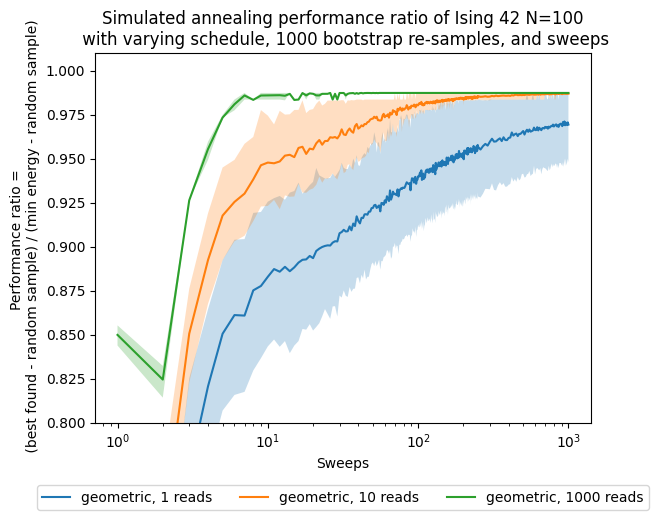

In [26]:
fig, ax = plt.subplots()
for boot in boots:
    for schedule in schedules:
        ax.plot(sweeps,results['best'][boot][schedule], label=str(schedule) + ', ' + str(boot) + ' reads')
        bestnp = np.stack(results['bestci'][boot][schedule], axis=0).T
        ax.fill_between(sweeps,bestnp[0],bestnp[1],alpha=0.25)
ax.set(xlabel='Sweeps')
ax.set(ylabel='Performance ratio = \n ' + '(best found - random sample) / (min energy - random sample)')
ax.set_title('Simulated annealing performance ratio of Ising 42 N=100\n' +
          ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15))
ax.set(xscale='log')
ax.set(ylim=[0.8,1.01])
# ax.set(xlim=[1,200])

Now, besides looking at the sweeps, which are our parameter, we want to see how the performance changes with respect to the number of shots, which in this case are proportional to the computational time/effort that it takes to solve the problem.

[(0.8, 1.01)]

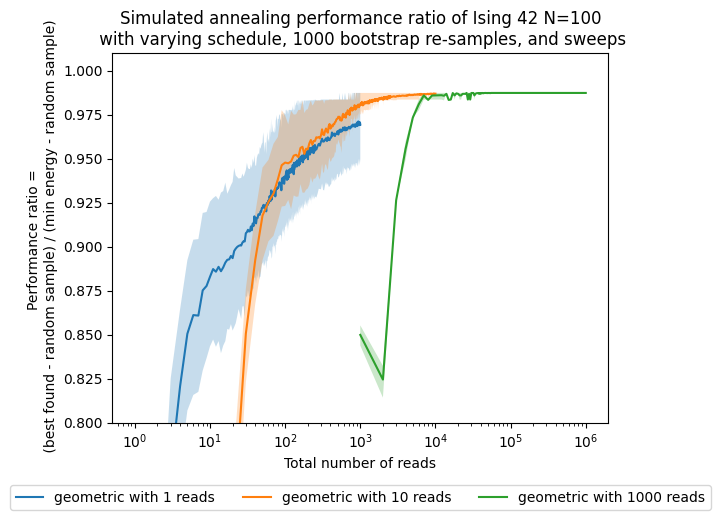

In [27]:
fig, ax = plt.subplots()
for boot in boots:
    reads = [s * boot for s in sweeps]
    for schedule in schedules:
        ax.plot(reads,results['best'][boot][schedule], label=str(schedule) + ' with ' + str(boot) + ' reads')
        bestnp = np.stack(results['bestci'][boot][schedule], axis=0).T
        ax.fill_between(reads,bestnp[0],bestnp[1],alpha=0.25)
ax.set(xlabel='Total number of reads')
ax.set(ylabel='Performance ratio = \n ' + '(best found - random sample) / (min energy - random sample)')
ax.set_title('Simulated annealing performance ratio of Ising 42 N=100\n' +
          ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15))
ax.set(xscale='log')
ax.set(ylim=[0.8,1.01])
# ax.set(xlim=[1,200])

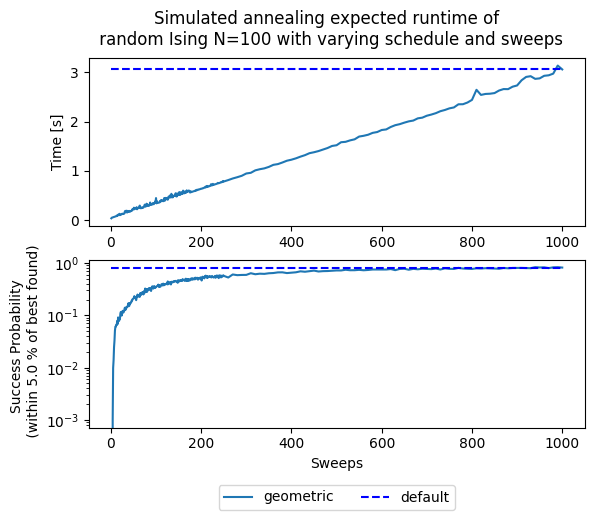

In [28]:
fig, (ax1,ax2) = plt.subplots(2)
fig.suptitle('Simulated annealing expected runtime of \n' +
             ' random Ising N=100 with varying schedule and sweeps')

for schedule in schedules:
    ax1.plot(sweeps, results['t'][schedule], '-', label=schedule)
ax1.hlines(results['t']['geometric'][-1], sweeps[0], sweeps[-1],
           linestyle='--', label='default', colors='b')

ax1.set(ylabel='Time [s]')
# ax1.set(xlim=[1,200])


for schedule in schedules:
    ax2.semilogy(sweeps, results['p'][default_sweeps][schedule], '-', label=schedule)
ax2.hlines(results['p'][default_sweeps]['geometric'][-1], sweeps[0], sweeps[-1],
           linestyle='--', label='default', colors='b')
# ax2.set(xlim=[1,200])

ax2.set(ylabel='Success Probability \n (within '+ str(treshold) +' % of best found)')
ax2.set(xlabel='Sweeps')
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.3))

# Add plot going all the way to 1000 sweeps


minimum TTS for geometric schedule = 3.2688155801866294s at sweep = 126


[Text(0.5, 0, 'Sweeps')]

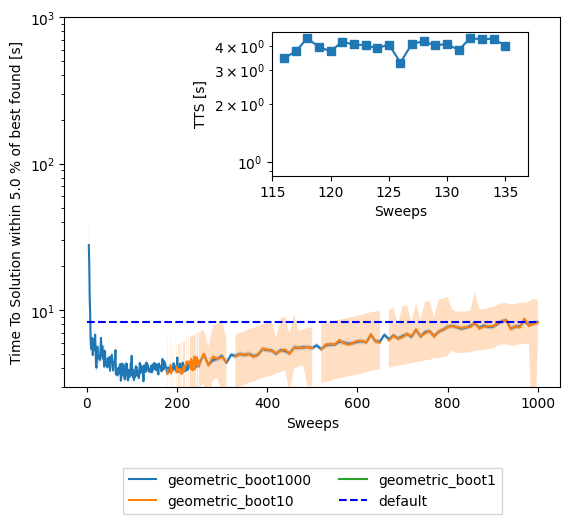

In [29]:
fig1, ax1 = plt.subplots()

for boot in reversed(boots):
    for schedule in schedules:
        ax1.plot(sweeps,results['tts'][boot][schedule], label=schedule + "_boot" + str(boot))
        ttsnp = np.stack(results['ttsci'][boot][schedule], axis=0).T
        ax1.fill_between(sweeps,ttsnp[0],ttsnp[1],alpha=0.25)


ax1.hlines(results['tts'][total_reads]['geometric'][-1], sweeps[0], sweeps[-1],
           linestyle='--', label='default', colors='b')

ax1.set(yscale='log')
ax1.set(ylim=[3,1e3])
# ax1.set(xlim=[1,200])

ax1.set(ylabel='Time To Solution within '+ str(treshold) +' % of best found [s]')
ax1.set(xlabel='Sweeps')
ax.set_title('Simulated annealing expected runtime of random Ising N=100\n' +
          ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=2, fancybox=False, shadow=False)

ax2 = plt.axes([.45, .55, .4, .3])
for schedule in schedules:
    min_tts = min(results['tts'][default_sweeps][schedule])
    min_index = results['tts'][default_sweeps][schedule].index(min_tts)
    min_sweep = sweeps[results['tts'][default_sweeps][schedule].index(min_tts)]
    print("minimum TTS for " + schedule + " schedule = " + str(min_tts) + "s at sweep = " + str(min_sweep))
    for boot in reversed(boots):
        ax2.semilogy(sweeps[min_index-10:min_index+10], results['tts'][boot][schedule][min_index-10:min_index+10], '-s')
ax2.hlines(results['tts'][default_sweeps]['geometric'][-1], sweeps[min_index-10], sweeps[min_index+10],
           linestyle='--', label='default', colors='b')

ax2.set(ylabel='TTS [s]')
ax2.set(xlabel='Sweeps')

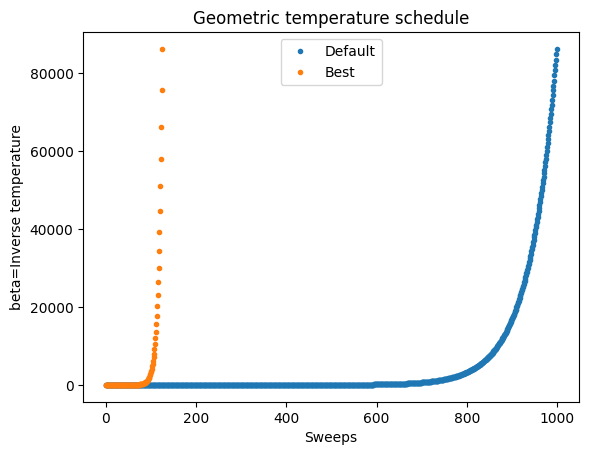

In [30]:
min_beta_schedule = np.geomspace(*simAnnSamplesDefault.info['beta_range'], num=min_sweep)
fig, ax = plt.subplots()
ax.plot(beta_schedule,'.')
ax.plot(min_beta_schedule,'.')
ax.set_xlabel('Sweeps')
ax.set_ylabel('beta=Inverse temperature')
ax.set_title('Geometric temperature schedule')
plt.legend(['Default','Best'])

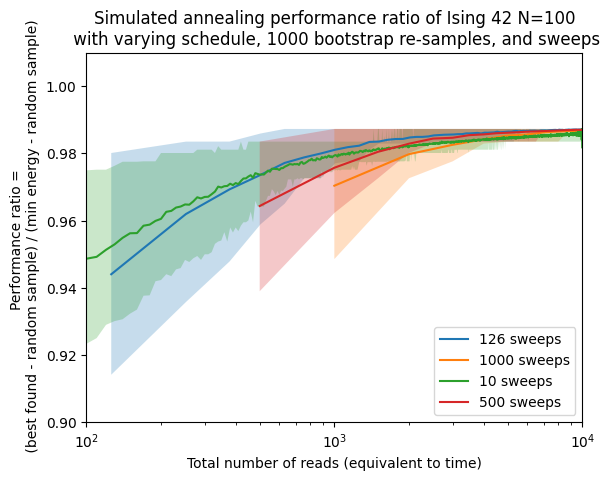

In [31]:
fig, ax = plt.subplots()
# Best of boot samples es computed via n_boot bootstrapping
# n_boot=500
boots = range(1,1000,1)
interest_sweeps = [min_sweep, default_sweeps, 10, 500]
approx_ratio = {}
approx_ratioci = {}

for schedul in schedules:
    approx_ratio[schedule] = {}
    approx_ratioci[schedule] = {}

# Gather instance names
instance = 42
for sweep in interest_sweeps:
    for schedule in schedules:
        if sweep in approx_ratio[schedule] and sweep in approx_ratioci[schedule]:
            pass
        else:
            min_energy = results['min_energy'][schedule]
            random_energy = results['random_energy'][schedule]

            pickle_name = str(instance) + "_" + schedule + "_" + str(sweep) + ".p"
            pickle_name = os.path.join(pickle_path, pickle_name)
            # If the instance data exists, load the data
            if os.path.exists(pickle_name) and not overwrite_pickles:
                # print(pickle_name)
                samples = pickle.load(open(pickle_name, "rb"))
                time_s = samples.info['timing']
            # If it does not exist, generate the data
            else:
                start = time.time()
                samples = simAnnSampler.sample(model_random, num_reads=total_reads, num_sweeps=sweep, beta_schedule_type=schedule)
                time_s = time.time() - start
                samples.info['timing'] = time_s
                pickle.dump(samples, open(pickle_name, "wb"))
            # Compute statistics
            energies=samples.data_vectors['energy']
            if min(energies) < min_energy:
                min_energy = min(energies)
                print("A better solution of " + str(min_energy) + " was found for sweep " + str(sweep))

            b = []
            bcs = []
            probs = []
            time_to_sol = []
            for boot in boots:
                boot_dist = []
                pr_dist = []
                for i in range(int(n_boot - boot + 1)):
                    resampler = np.random.randint(0, total_reads, boot)
                    sample_boot = energies.take(resampler, axis=0)
                    # Compute the best along that axis
                    boot_dist.append(min(sample_boot))   
                
                b.append(np.mean(boot_dist))
                # Confidence intervals from bootstrapping the best out of boot
                bnp = np.array(boot_dist)
                cilo = np.apply_along_axis(stats.scoreatpercentile, 0, bnp, 50.-ci/2.)
                ciup = np.apply_along_axis(stats.scoreatpercentile, 0, bnp, 50.+ci/2.)  
                bcs.append((cilo,ciup))

            approx_ratio[schedule][sweep] = [(random_energy - energy) / (random_energy - min_energy) for energy in b]
            approx_ratioci[schedule][sweep] = [tuple((random_energy - element) / (random_energy - min_energy) for element in energy) for energy in bcs]

        ax.plot([shot*sweep for shot in boots], approx_ratio[schedule][sweep], label=str(sweep) + ' sweeps')
        approx_ratio_bestci_np = np.stack(approx_ratioci[schedule][sweep], axis=0).T
        ax.fill_between([shot*sweep for shot in boots],approx_ratio_bestci_np[0],approx_ratio_bestci_np[1],alpha=0.25)
ax.set(xscale='log')
ax.set(ylim=[0.9,1.01])
ax.set(xlim=[1e2,1e4])
ax.set(xlabel='Total number of reads (equivalent to time)')
ax.set(ylabel='Performance ratio = \n ' + '(best found - random sample) / (min energy - random sample)')
ax.set_title('Simulated annealing performance ratio of Ising 42 N=100\n' +
          ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')
plt.legend()


Here see how using the optimal number of sweeps is better than using other values (including the default recommended by the solver) in terms of solving this problem.
Obviously, we only know this after running the experiments and verifying it ourselves. This is not the usual case, so we want to see how well can we do if we solve similar (but no the same instances).
Here we will generate 20 random instances from the same distribution and size but different random seed. 

In [32]:

s = 0.99  # This is the success probability for the TTS calculation
treshold = 5.0  # This is a percentual treshold of what the minimum energy should be
sweeps = list(chain(np.arange(1, 250, 1), np.arange(250, 1001, 10)))
# schedules = ['geometric', 'linear']
schedules = ['geometric']
total_reads = 1000
default_sweeps = 1000
# boots = [1, 10, 100, default_sweeps]
boots = [1, 10, default_sweeps]
all_results = {}
instances = range(20)

all_results_name = "all_results.pkl"
all_results_name = os.path.join(pickle_path, all_results_name)
# If you wanto to use the raw data and process it here
if not(os.path.exists(all_results_name)):

    for instance in instances:
        all_results[instance] = {}
        all_results[instance]['p'] = {}
        all_results[instance]['min_energy'] = {}
        all_results[instance]['random_energy'] = {}
        all_results[instance]['tts'] = {}
        all_results[instance]['ttsci'] = {}
        all_results[instance]['t']= {}
        all_results[instance]['best'] = {}
        all_results[instance]['bestci'] = {}

        np.random.seed(instance)  # Fixing the random seed to get the same result
        J = np.random.rand(N, N)
        # We only consider upper triangular matrix ignoring the diagonal
        J = np.triu(J, 1)
        h = np.random.rand(N)
        model_random = dimod.BinaryQuadraticModel.from_ising(h, J, offset=0.0)

        randomSample = randomSampler.sample(model_random, num_reads=total_reads)
        random_energies = [datum.energy for datum in randomSample.data(
                ['energy'])]
        random_energy = np.mean(random_energies)

        default_pickle_name = str(instance) + "_geometric_1000.p"
        default_pickle_name = os.path.join(pickle_path, default_pickle_name)
        if os.path.exists(default_pickle_name) and not overwrite_pickles:
            simAnnSamplesDefault = pickle.load(open(default_pickle_name, "rb"))
            timeDefault = simAnnSamplesDefault.info['timing']
        else:
            start = time.time()
            simAnnSamplesDefault = simAnnSampler.sample(model_random, num_reads=1000)
            timeDefault = time.time() - start
            simAnnSamplesDefault.info['timing'] = timeDefault
            pickle.dump(simAnnSamplesDefault, open(default_pickle_name, "wb"))
        energies = [datum.energy for datum in simAnnSamplesDefault.data(
            ['energy'], sorted_by='energy')]
        min_energy = energies[0]
        for schedule in schedules:

            all_results[instance]['t'][schedule] = {}
            all_results[instance]['min_energy'][schedule] = {}
            all_results[instance]['random_energy'][schedule] = {}
            all_results[instance]['p'][schedule] = {}
            all_results[instance]['tts'][schedule] = {}
            all_results[instance]['ttsci'][schedule] = {}
            all_results[instance]['best'][schedule] = {}
            all_results[instance]['bestci'][schedule] = {}

            # probs = []
            probs = {k: [] for k in boots}
            time_to_sol = {k: [] for k in boots}
            prob_np = {k: [] for k in boots}
            ttscs = {k: [] for k in boots}
            times = []
            b = {k: [] for k in boots}
            bnp = {k: [] for k in boots}
            bcs = {k: [] for k in boots}
            for sweep in sweeps:
                # Gather instance names
                pickle_name = str(instance) + "_" + schedule + "_" + str(sweep) + ".p"
                pickle_name = os.path.join(pickle_path, pickle_name)
                # If the instance data exists, load the data
                if os.path.exists(pickle_name) and not overwrite_pickles:
                    samples = pickle.load(open(pickle_name, "rb"))
                    time_s = samples.info['timing']
                # If it does not exist, generate the data
                else:
                    start = time.time()
                    samples = simAnnSampler.sample(
                        model_random, num_reads=1000, num_sweeps=sweep, beta_schedule_type=schedule)
                    time_s = time.time() - start
                    samples.info['timing'] = time_s
                    pickle.dump(samples, open(pickle_name, "wb"))
                # Compute statistics
                energies = samples.data_vectors['energy']
                occurrences = samples.data_vectors['num_occurrences']
                total_counts = sum(occurrences)
                times.append(time_s)
                if min(energies) < min_energy:
                    min_energy = min(energies)
                    # print("A better solution of " + str(min_energy) + " was found for sweep " + str(sweep))
                # success = min_energy*(1.0 + treshold/100.0)**np.sign(min_energy)
                success = random_energy - (random_energy - min_energy)*(1.0 - treshold/100.0)
                
                # Best of boot samples es computed via n_boot bootstrapping
                ci=68
                boot_dist = {}
                pr_dist = {}
                cilo = {}
                ciup = {}
                pr = {}
                pr_cilo = {}
                pr_ciup = {}
                for boot in boots:
                    boot_dist[boot] = []
                    pr_dist[boot] = []
                    for i in range(int(n_boot)):
                        resampler = np.random.randint(0, total_reads, boot)
                        sample_boot = energies.take(resampler, axis=0)
                        # Compute the best along that axis
                        boot_dist[boot].append(min(sample_boot))
        
                        occurences = occurrences.take(resampler, axis=0)
                        counts = {}
                        for index, energy in enumerate(sample_boot):
                            if energy in counts.keys():
                                counts[energy] += occurences[index]
                            else:
                                counts[energy] = occurences[index]
                        pr_dist[boot].append(sum(counts[key] for key in counts.keys() if key < success)/boot)
                    prob_np[boot] = np.array(pr_dist[boot])
                    pr[boot] = np.mean(prob_np[boot])
                    probs[boot].append(pr[boot])
                    
                    b[boot].append(np.mean(boot_dist[boot]))
                    # Confidence intervals from bootstrapping the best out of boot
                    bnp[boot] = np.array(boot_dist[boot])
                    cilo[boot] = np.apply_along_axis(stats.scoreatpercentile, 0, bnp[boot], 50.-ci/2.)
                    ciup[boot] = np.apply_along_axis(stats.scoreatpercentile, 0, bnp[boot], 50.+ci/2.)  
                    bcs[boot].append((cilo[boot],ciup[boot]))
                    # Confidence intervals from bootstrapping the TTS of boot
                    if prob_np[boot].all() == 0:
                        time_to_sol[boot].append(np.inf)
                        ttscs[boot].append((np.inf, np.inf))
                    else:
                        pr_cilo[boot] = np.apply_along_axis(stats.scoreatpercentile, 0, prob_np[boot], 50.-ci/2.)
                        pr_ciup[boot] = np.apply_along_axis(stats.scoreatpercentile, 0, prob_np[boot], 50.+ci/2.)
                        time_to_sol[boot].append(time_s*math.log10(1-s)/math.log10(1-pr[boot]+1e-9))   
                        ttscs[boot].append((time_s*math.log10(1-s)/math.log10(1-pr_cilo[boot]+1e-9),time_s*math.log10(1-s)/math.log10(1-pr_ciup[boot]+1e-9)))
                    

            all_results[instance]['t'][schedule][default_sweeps] = times
            all_results[instance]['min_energy'][schedule][default_sweeps] = min_energy
            all_results[instance]['random_energy'][schedule][default_sweeps] = random_energy
            for boot in boots:
                all_results[instance]['p'][schedule][boot] = probs[boot]
                all_results[instance]['tts'][schedule][boot] = time_to_sol[boot]
                all_results[instance]['ttsci'][schedule][boot] = ttscs[boot]
                all_results[instance]['best'][schedule][boot] = [(random_energy - energy) / (random_energy - min_energy) for energy in b[boot]]
                all_results[instance]['bestci'][schedule][boot] = [tuple((random_energy - element) / (random_energy - min_energy) for element in energy) for energy in bcs[boot]]

    # Save results file in case that we are interested in reusing them
    pickle.dump(all_results, open(all_results_name, "wb"))
else: # Just reload processed datafile
    all_results = pickle.load(open(all_results_name, "rb"))

In [33]:
def bootstrap(data, n_boot=1000, ci=68):
    boot_dist = []
    for i in range(int(n_boot)):
        resampler = np.random.randint(0, data.shape[0], data.shape[0])
        sample = data.take(resampler, axis=0)
        # Median ignoring nans instead of mean
        boot_dist.append(np.nanmedian(sample, axis=0))
    b = np.array(boot_dist)
    s1 = np.apply_along_axis(stats.scoreatpercentile, 0, b, 50.-ci/2.)
    s2 = np.apply_along_axis(stats.scoreatpercentile, 0, b, 50.+ci/2.)
    return (s1,s2)
    
def tsplotboot(ax, x, data, error_est, **kw):
    if x is None:
        x = np.arange(data.shape[1])
    # Median ignoring nans instead of mean
    est = np.nanmedian(data, axis=0)
    mask = ~np.isnan(est)
    if error_est == 'bootstrap':
        cis = bootstrap(data)
    elif error_est == 'std':
        sd = np.nanstd(data, axis=0)
        cis = (est - sd, est + sd)
    ax.fill_between(x[mask],cis[0][mask],cis[1][mask],alpha=0.35, **kw)
    ax.plot(x[mask],est[mask],**kw)
    ax.margins(x=0)

Now we bootstrap our solutions with respect to the whole set of instances, or ensemble, and we use the median which respresents the solution better than the mean.

minimum median TTS for geometric schedule = infs at sweep = 137
minimum TTS for instance 42 with geometric schedule = 3.2688155801866294s at sweep = 126


[Text(0.5, 0, 'Sweeps')]

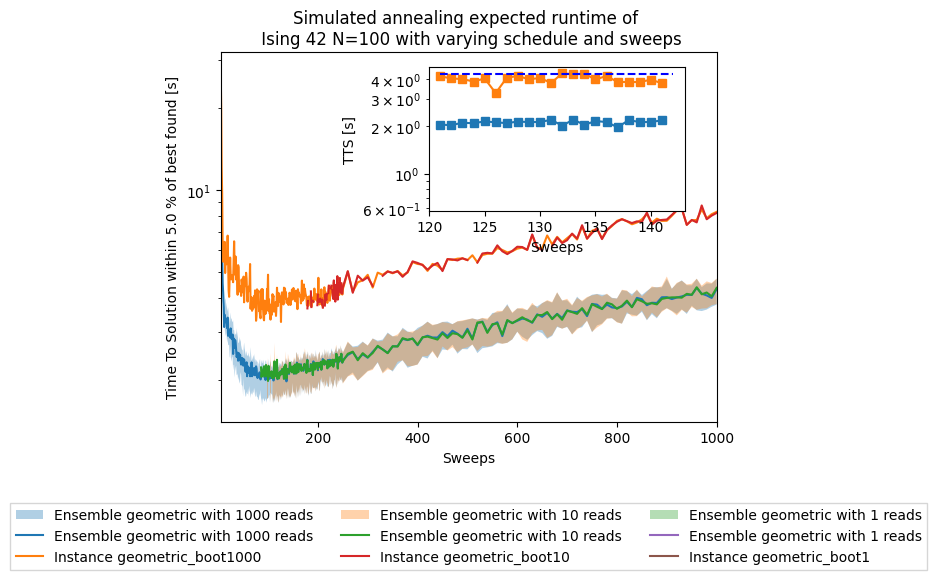

In [34]:
fig, ax1 = plt.subplots()

for boot in reversed(boots):
    for schedule in schedules:
        results_array = np.array([np.array(all_results[i]['tts'][schedule][boot]) for i in range(20)])
        min_median_tts = min(np.nanmedian(results_array, axis=0))
        tsplotboot(ax1, x=np.asarray(sweeps), data=results_array, error_est='bootstrap', label="Ensemble " + schedule + ' with ' + str(boot) + ' reads')

        ax1.plot(sweeps,results['tts'][boot][schedule], label="Instance " + schedule + "_boot" + str(boot))


ax1.set(yscale='log')

ax1.set(ylabel='Time To Solution within '+ str(treshold) +' % of best found [s]')
ax1.set(xlabel='Sweeps')
plt.title('Simulated annealing expected runtime of \n' +
          ' Ising 42 N=100 with varying schedule and sweeps')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=False, shadow=False)

ax2 = plt.axes([.45, .55, .4, .3])
for schedule in schedules:
    results_array = np.array([np.array(all_results[i]['tts'][schedule][default_sweeps]) for i in range(20)])
    min_median_index = np.argmin(np.nanmedian(results_array, axis=0))
    min_median_sweep = sweeps[min_median_index]
    min_tts = min(results['tts'][default_sweeps][schedule])
    min_index = results['tts'][default_sweeps][schedule].index(min_tts)
    min_sweep = sweeps[results['tts'][default_sweeps][schedule].index(min_tts)]
    if min_sweep < min_median_sweep:
        index_lo = min_index
        index_hi = min_median_index
    else:
        index_lo = min_median_index
        index_hi = min_index
    print("minimum median TTS for " + schedule + " schedule = " + str(min_median_tts) + "s at sweep = " + str(min_median_sweep))
    ax2.semilogy(sweeps[index_lo-5:index_hi+5],
        np.median([all_results[i]['tts'][schedule][default_sweeps] for i in range(20)],axis=0)
        [index_lo-5:index_hi+5], '-s')
    print("minimum TTS for instance 42 with " + schedule + " schedule = " + str(min_tts) + "s at sweep = " + str(min_sweep))
    ax2.semilogy(sweeps[index_lo-5:index_hi+5], 
        results['tts'][default_sweeps][schedule][index_lo-5:index_hi+5], '-s')
    
    
ax2.hlines(np.median([all_results[i]['tts'][schedule][default_sweeps][-1] for i in range(20)]),
        sweeps[index_lo-5], sweeps[index_hi+5],
           linestyle='--', label='default', colors='b')

ax2.set(ylabel='TTS [s]')
ax2.set(xlabel='Sweeps')

[(0.8, 1.01)]

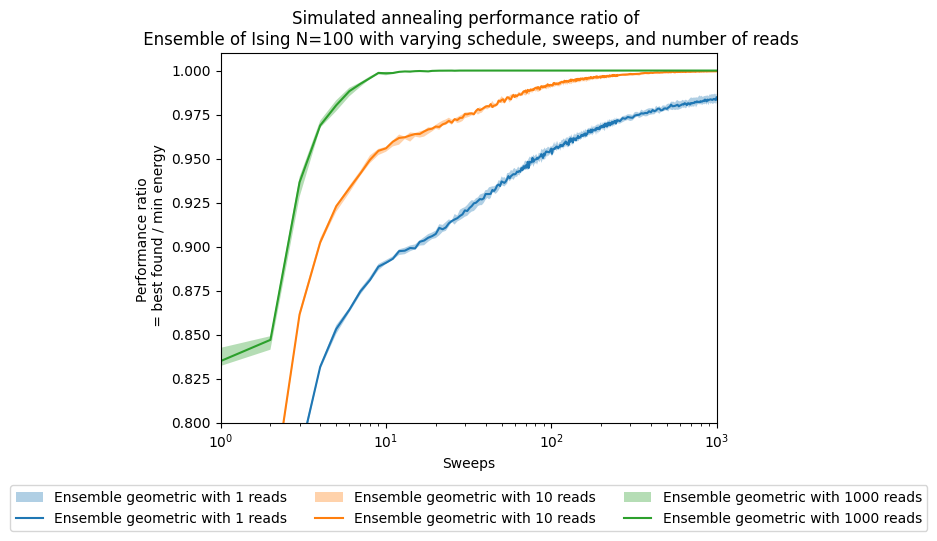

In [35]:
fig, ax = plt.subplots()
for boot in boots:
    for schedule in schedules:
        best_array = np.array([np.array(all_results[i]['best'][schedule][boot]) for i in range(20)])
        # min_median_best = min(np.nanmedian(results_array, axis=0))
        tsplotboot(ax, x=np.asarray(sweeps), data=best_array, error_est='bootstrap', label="Ensemble " + schedule + ' with ' + str(boot) + ' reads')
ax.set(xlabel='Sweeps')
ax.set(ylabel='Performance ratio \n = best found / min energy')
ax.set_title('Simulated annealing performance ratio of \n' +
          ' Ensemble of Ising N=100 with varying schedule, sweeps, and number of reads')
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15))
ax.set(xscale='log')
ax.set(ylim=[0.8,1.01])
# ax.set(xlim=[1,200])

[(0.8, 1.01)]

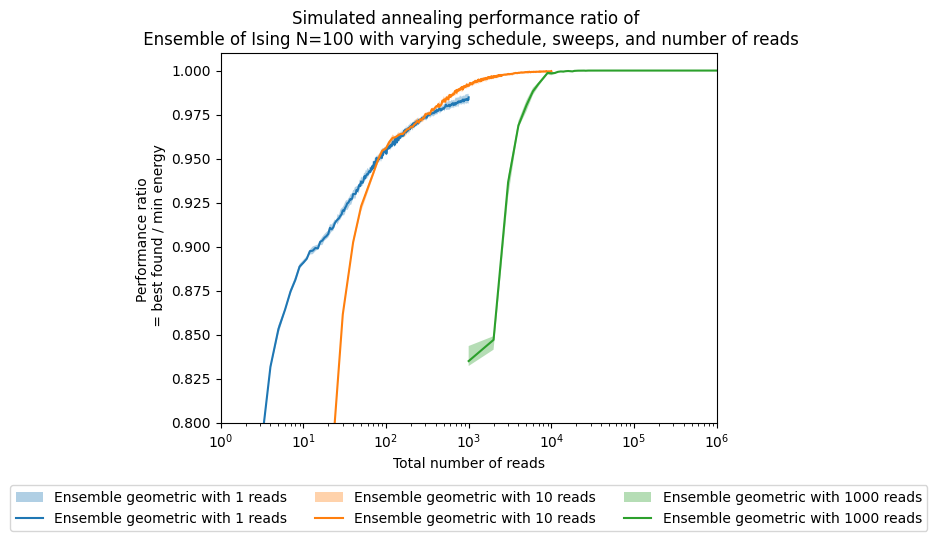

In [36]:
fig, ax = plt.subplots()
for boot in boots:
    reads = [s * boot for s in sweeps]
    for schedule in schedules:
        best_array = np.array([np.array(all_results[i]['best'][schedule][boot]) for i in range(20)])
        # min_median_best = min(np.nanmedian(results_array, axis=0))
        tsplotboot(ax, x=np.asarray(reads), data=best_array, error_est='bootstrap', label="Ensemble " + schedule + ' with ' + str(boot) + ' reads')
ax.set(xlabel='Total number of reads')
ax.set(ylabel='Performance ratio \n = best found / min energy')
ax.set_title('Simulated annealing performance ratio of \n' +
          ' Ensemble of Ising N=100 with varying schedule, sweeps, and number of reads')
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15))
ax.set(xscale='log')
ax.set(ylim=[0.8,1.01])
# ax.set(xlim=[1,200])

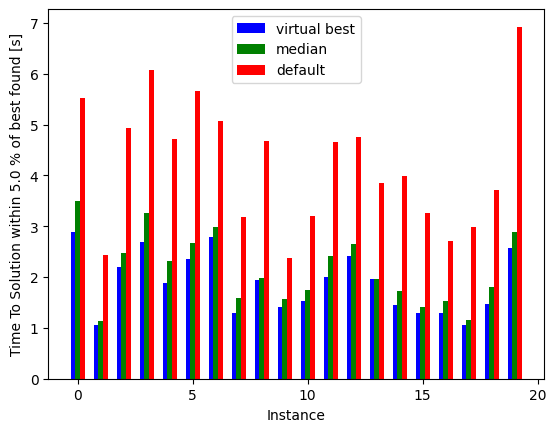

In [37]:
fig, ax = plt.subplots()
instances = np.arange(20)
indices = [np.argmin(all_results[i]['tts']['geometric'][default_sweeps]) for i in range(20)]
minima = [np.min(all_results[i]['tts']['geometric'][default_sweeps]) for i in range(20)]
default = [all_results[i]['tts']['geometric'][default_sweeps][-1] for i in range(20)]
median_all = [all_results[i]['tts']['geometric'][default_sweeps][min_median_index] for i in range(20)]


ax.bar(instances-0.2, minima, width=0.2, color='b', align='center', label='virtual best')
ax.bar(instances, median_all, width=0.2, color='g', align='center', label='median')
ax.bar(instances+0.2, default, width=0.2, color='r', align='center', label='default')
ax.xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('Instance')
ax.set(ylabel='Time To Solution within '+ str(treshold) +' % of best found [s]')
plt.legend()

Notice how much performance would we be losing if we had used the default value for all these instances, and how much we could eventually win if we knew the best for each.

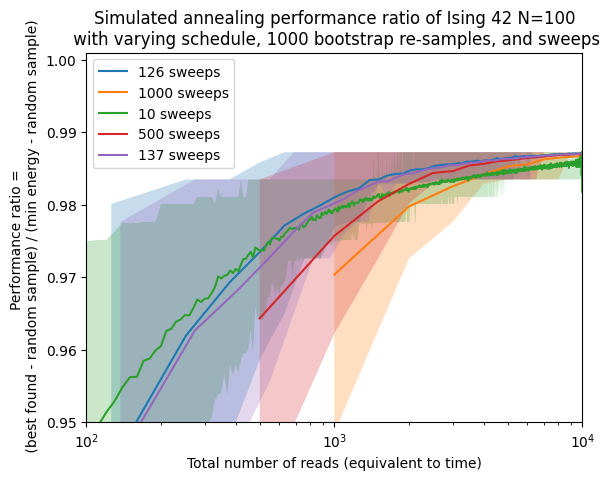

In [38]:
fig, ax = plt.subplots()
interest_sweeps = [min_sweep, total_reads, 10, 500]
interest_sweeps.append(min_median_sweep)
shots = range(1,1000,1)
n_boot = 1000

# Gather instance names
instance = 42
for sweep in interest_sweeps:
    for schedule in schedules:
        if sweep in approx_ratio[schedule] and sweep in approx_ratioci[schedule]:
            pass
        else:
            min_energy = results['min_energy'][schedule]
            random_energy = results['random_energy'][schedule]
            
            pickle_name = str(instance) + "_" + schedule + "_" + str(sweep) + ".p"
            pickle_name = os.path.join(pickle_path, pickle_name)
            # If the instance data exists, load the data
            if os.path.exists(pickle_name) and not overwrite_pickles:
                # print(pickle_name)
                samples = pickle.load(open(pickle_name, "rb"))
                time_s = samples.info['timing']
            # If it does not exist, generate the data
            else:
                start = time.time()
                samples = simAnnSampler.sample(model_random, num_reads=total_reads, num_sweeps=sweep, beta_schedule_type=schedule)
                time_s = time.time() - start
                samples.info['timing'] = time_s
                pickle.dump(samples, open(pickle_name, "wb"))
            # Compute statistics
            energies=samples.data_vectors['energy']
            if min(energies) < min_energy:
                min_energy = min(energies)
                print("A better solution of " + str(min_energy) + " was found for sweep " + str(sweep))

            b = []
            bcs = []
            probs = []
            time_to_sol = []
            for shot in shots:
                shot_dist = []
                pr_dist = []
                for i in range(int(n_boot - shot + 1)):
                    resampler = np.random.randint(0, total_reads, shot)
                    sample_shot = energies.take(resampler, axis=0)
                    # Compute the best along that axis
                    shot_dist.append(min(sample_shot))   
                
                b.append(np.mean(shot_dist))
                # Confidence intervals from bootstrapping the best out of shot
                bnp = np.array(shot_dist)
                cilo = np.apply_along_axis(stats.scoreatpercentile, 0, bnp, 50.-ci/2.)
                ciup = np.apply_along_axis(stats.scoreatpercentile, 0, bnp, 50.+ci/2.)  
                bcs.append((cilo,ciup))
            
            approx_ratio[schedule][sweep] = [(random_energy - energy) / (random_energy - min_energy) for energy in b]
            approx_ratioci[schedule][sweep] = [tuple((random_energy - element) / (random_energy - min_energy) for element in energy) for energy in bcs]

        ax.plot([shot*sweep for shot in shots], approx_ratio[schedule][sweep], label=str(sweep) + ' sweeps')
        approx_ratio_bestci_np = np.stack(approx_ratioci[schedule][sweep], axis=0).T
        ax.fill_between([shot*sweep for shot in shots],approx_ratio_bestci_np[0],approx_ratio_bestci_np[1],alpha=0.25)
ax.set(xscale='log')
ax.set(ylim=[0.95,1.001])
ax.set(xlim=[1e2,1e4])
ax.set(xlabel='Total number of reads (equivalent to time)')
ax.set(ylabel='Performance ratio = \n ' + '(best found - random sample) / (min energy - random sample)')
ax.set_title('Simulated annealing performance ratio of Ising 42 N=100\n' +
          ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')
plt.legend()